In [1]:
import gymnasium
import gymnasium_env
env = gymnasium.make('gymnasium_env/GridWorld-v0')

In [2]:
# Check the environment properties
print("Action space:", env.action_space)
print("Number of actions:", env.action_space.n)
print("Observation space:", env.observation_space)
print("Environment size:", env.unwrapped.size)

# Check what each action represents
from gymnasium_env.envs.grid_world import Actions
print("\nActions mapping:")
for action in Actions:
    print(f"Action {action.value}: {action.name}")

Action space: Discrete(5)
Number of actions: 5
Observation space: Dict('agent': Box(0, 4, (2,), int64), 'target': Box(0, 4, (2,), int64))
Environment size: 5

Actions mapping:
Action 0: right
Action 1: up
Action 2: left
Action 3: down
Action 4: diagonal_down_right


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

class QLearningAgent: 
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Initialize Q-table as a defaultdict
        # State will be represented as (agent_x, agent_y, target_x, target_y)
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))
        
        # For tracking performance
        self.episode_rewards = []
        self.episode_lengths = []
    
    def state_to_key(self, observation):
        """Convert observation dict to a hashable state key"""
        agent_pos = tuple(observation['agent'])
        target_pos = tuple(observation['target'])
        return agent_pos + target_pos
    
    def choose_action(self, state_key):
        """Choose action using epsilon-greedy policy"""
        if random.random() < self.epsilon:
            return self.env.action_space.sample()  # Random action
        else:
            return np.argmax(self.q_table[state_key])  # Greedy action
    
    def update_q_table(self, state_key, action, reward, next_state_key, done):
        """Update Q-table using Q-learning update rule"""
        current_q = self.q_table[state_key][action]
        
        if done:
            # Terminal state: Q(s',a') = 0
            target_q = reward
        else:
            # Non-terminal state: Q(s',a') = max over actions of Q(s',a')
            target_q = reward + self.discount_factor * np.max(self.q_table[next_state_key])
        
        # Q-learning update rule
        self.q_table[state_key][action] = current_q + self.learning_rate * (target_q - current_q)
    
    def train(self, num_episodes=1000, max_steps_per_episode=200):
        """Train the Q-learning agent"""
        print(f"Training Q-learning agent for {num_episodes} episodes...")
        
        for episode in range(num_episodes):
            observation, _ = self.env.reset()
            state_key = self.state_to_key(observation)
            
            total_reward = 0
            steps = 0
            
            for step in range(max_steps_per_episode):
                # Choose action
                action = self.choose_action(state_key)
                
                # Take action
                next_observation, reward, terminated, truncated, _ = self.env.step(action)
                next_state_key = self.state_to_key(next_observation)
                done = terminated or truncated
                
                # Update Q-table
                self.update_q_table(state_key, action, reward, next_state_key, done)
                
                # Update state
                state_key = next_state_key
                total_reward += reward
                steps += 1
                
                if done:
                    break
            
            # Decay epsilon
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            
            # Store episode results
            self.episode_rewards.append(total_reward)
            self.episode_lengths.append(steps)
            
            # Print progress
            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(self.episode_rewards[-100:])
                avg_length = np.mean(self.episode_lengths[-100:])
                print(f"Episode {episode + 1}/{num_episodes}, "
                      f"Avg Reward (last 100): {avg_reward:.2f}, "
                      f"Avg Length (last 100): {avg_length:.2f}, "
                      f"Epsilon: {self.epsilon:.3f}")
    
    def test(self, num_episodes=10, render=False):
        """Test the trained agent"""
        print(f"\nTesting agent for {num_episodes} episodes...")
        test_rewards = []
        test_lengths = []
        
        # Temporarily disable exploration
        old_epsilon = self.epsilon
        self.epsilon = 0.0
        
        for episode in range(num_episodes):
            observation, _ = self.env.reset()
            state_key = self.state_to_key(observation)
            
            total_reward = 0
            steps = 0
            
            while steps < 200:  # Max steps limit
                action = self.choose_action(state_key)
                observation, reward, terminated, truncated, _ = self.env.step(action)
                state_key = self.state_to_key(observation)
                
                total_reward += reward
                steps += 1
                
                if terminated or truncated:
                    break
            
            test_rewards.append(total_reward)
            test_lengths.append(steps)
            
            print(f"Test Episode {episode + 1}: Reward = {total_reward}, Steps = {steps}")
        
        # Restore epsilon
        self.epsilon = old_epsilon
        
        print(f"\nTest Results:")
        print(f"Average Reward: {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
        print(f"Average Steps: {np.mean(test_lengths):.2f} ± {np.std(test_lengths):.2f}")
        print(f"Success Rate: {np.mean([r > 0 for r in test_rewards]) * 100:.1f}%")
        
        return test_rewards, test_lengths
    
    def plot_training_progress(self):
        """Plot training progress"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot rewards
        ax1.plot(self.episode_rewards)
        ax1.set_title('Episode Rewards During Training')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Total Reward')
        ax1.grid(True)
        
        # Plot episode lengths
        ax2.plot(self.episode_lengths)
        ax2.set_title('Episode Lengths During Training')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Steps to Complete')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

print("Q-learning agent class defined successfully!")

Q-learning agent class defined successfully!


In [4]:
# Create and train the Q-learning agent
agent = QLearningAgent(
    env=env,
    learning_rate=0.1,
    discount_factor=0.99,
    epsilon=1.0,          # Start with full exploration
    epsilon_decay=0.995,  # Decay exploration over time
    epsilon_min=0.01      # Minimum exploration rate
)

# Train the agent
agent.train(num_episodes=1000, max_steps_per_episode=200)

Training Q-learning agent for 1000 episodes...
Episode 100/1000, Avg Reward (last 100): 0.72, Avg Length (last 100): 85.39, Epsilon: 0.606
Episode 200/1000, Avg Reward (last 100): 0.73, Avg Length (last 100): 63.59, Epsilon: 0.367
Episode 300/1000, Avg Reward (last 100): 0.72, Avg Length (last 100): 60.56, Epsilon: 0.222
Episode 400/1000, Avg Reward (last 100): 0.74, Avg Length (last 100): 58.81, Epsilon: 0.135
Episode 500/1000, Avg Reward (last 100): 0.77, Avg Length (last 100): 50.87, Epsilon: 0.082
Episode 600/1000, Avg Reward (last 100): 0.81, Avg Length (last 100): 43.08, Epsilon: 0.049
Episode 700/1000, Avg Reward (last 100): 0.78, Avg Length (last 100): 48.73, Epsilon: 0.030
Episode 800/1000, Avg Reward (last 100): 0.72, Avg Length (last 100): 59.02, Epsilon: 0.018
Episode 900/1000, Avg Reward (last 100): 0.85, Avg Length (last 100): 36.82, Epsilon: 0.011
Episode 1000/1000, Avg Reward (last 100): 0.86, Avg Length (last 100): 31.44, Epsilon: 0.010



Testing agent for 20 episodes...
Test Episode 1: Reward = 1, Steps = 6
Test Episode 2: Reward = 1, Steps = 9
Test Episode 3: Reward = 1, Steps = 8
Test Episode 4: Reward = 1, Steps = 3
Test Episode 5: Reward = 0, Steps = 200
Test Episode 6: Reward = 0, Steps = 200
Test Episode 7: Reward = 0, Steps = 200
Test Episode 8: Reward = 1, Steps = 1
Test Episode 9: Reward = 0, Steps = 200
Test Episode 10: Reward = 1, Steps = 4
Test Episode 11: Reward = 0, Steps = 200
Test Episode 12: Reward = 1, Steps = 7
Test Episode 13: Reward = 1, Steps = 6
Test Episode 14: Reward = 0, Steps = 200
Test Episode 15: Reward = 1, Steps = 3
Test Episode 16: Reward = 1, Steps = 6
Test Episode 17: Reward = 1, Steps = 1
Test Episode 18: Reward = 1, Steps = 9
Test Episode 19: Reward = 1, Steps = 2
Test Episode 20: Reward = 1, Steps = 3

Test Results:
Average Reward: 0.70 ± 0.46
Average Steps: 63.40 ± 89.45
Success Rate: 70.0%


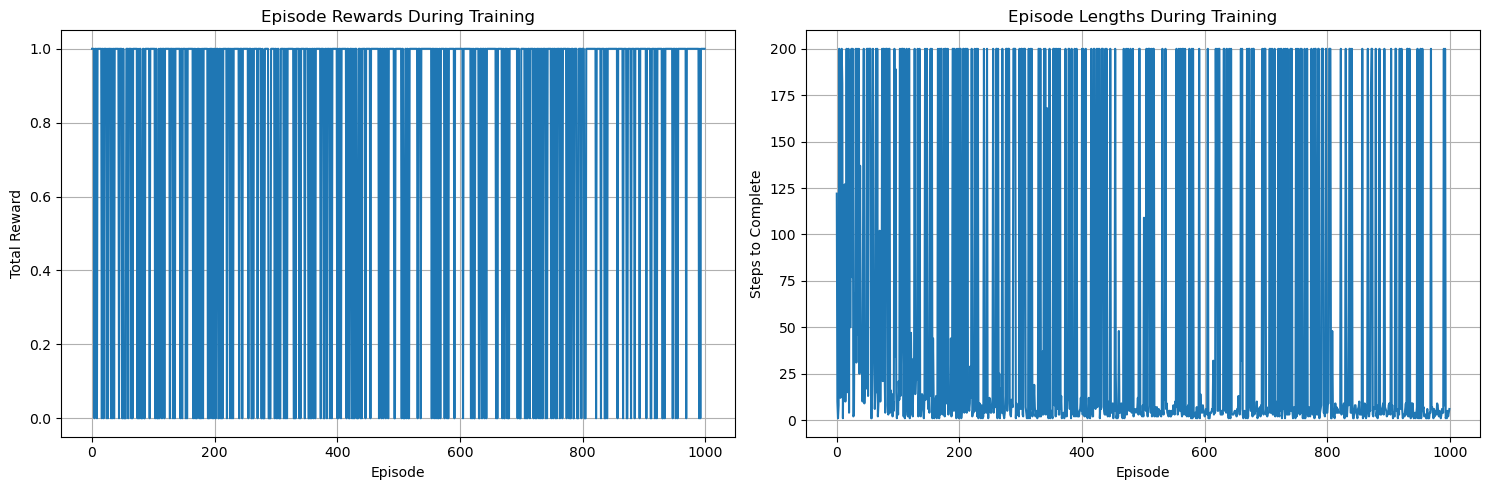

In [5]:
# Test the trained agent
test_rewards, test_lengths = agent.test(num_episodes=20)

# Plot training progress
agent.plot_training_progress()

Sample Q-values from the learned policy:
Total states learned: 584
State: Agent at (4, 0), Target at (1, 1)
Q-values: [0.         0.         0.00044816 0.         0.        ]
Best action: 2 (left)

State: Agent at (3, 0), Target at (1, 1)
Q-values: [0.         0.03941504 0.         0.         0.        ]
Best action: 1 (up)

State: Agent at (4, 1), Target at (1, 1)
Q-values: [0.00000000e+00 2.11517575e-02 7.80630836e-06 0.00000000e+00
 0.00000000e+00]
Best action: 1 (up)

State: Agent at (3, 1), Target at (1, 1)
Q-values: [7.88515996e-05 2.37832480e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Best action: 1 (up)

State: Agent at (4, 2), Target at (1, 1)
Q-values: [0.00000000e+00 0.00000000e+00 1.19977805e-01 0.00000000e+00
 5.77836789e-05]
Best action: 2 (left)



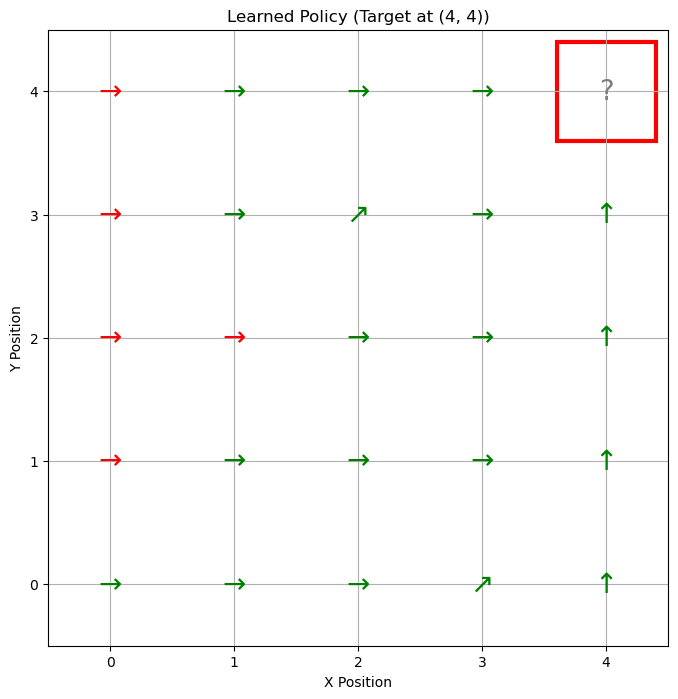

In [6]:
# Examine some learned Q-values
print("Sample Q-values from the learned policy:")
print(f"Total states learned: {len(agent.q_table)}")

# Show a few example states and their Q-values
count = 0
for state_key, q_values in agent.q_table.items():
    if count < 5:  # Show first 5 states
        agent_pos = state_key[:2]
        target_pos = state_key[2:]
        print(f"State: Agent at {agent_pos}, Target at {target_pos}")
        print(f"Q-values: {q_values}")
        print(f"Best action: {np.argmax(q_values)} ({['right', 'up', 'left', 'down', 'diagonal_down_right'][np.argmax(q_values)]})")
        print()
        count += 1

def visualize_policy(agent, env_size=5):
    """Visualize the learned policy for a specific target position"""
    # Let's visualize the policy when target is at position (4, 4) - top right corner
    target_pos = (4, 4)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Create a grid to show the best action for each agent position
    action_symbols = ['→', '↑', '←', '↓', '↗']  # right, up, left, down, diagonal_down_right
    
    for i in range(env_size):
        for j in range(env_size):
            agent_pos = (i, j)
            state_key = agent_pos + target_pos
            
            if state_key in agent.q_table:
                best_action = np.argmax(agent.q_table[state_key])
                symbol = action_symbols[best_action]
                
                # Color based on Q-value
                max_q = np.max(agent.q_table[state_key])
                color = 'green' if max_q > 0 else 'red'
            else:
                symbol = '?'
                color = 'gray'
            
            # Plot the symbol
            ax.text(i, j, symbol, ha='center', va='center', fontsize=20, color=color)
            
            # Mark target position
            if (i, j) == target_pos:
                ax.add_patch(plt.Rectangle((i-0.4, j-0.4), 0.8, 0.8, fill=False, edgecolor='red', linewidth=3))
    
    ax.set_xlim(-0.5, env_size-0.5)
    ax.set_ylim(-0.5, env_size-0.5)
    ax.set_xticks(range(env_size))
    ax.set_yticks(range(env_size))
    ax.grid(True)
    ax.set_title(f'Learned Policy (Target at {target_pos})')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    
    plt.show()

# Visualize the learned policy
visualize_policy(agent)

In [7]:
def demonstrate_agent(agent, env, num_episodes=3):
    """Demonstrate the agent playing episodes step by step"""
    action_names = ['right', 'up', 'left', 'down', 'diagonal_down_right']
    
    # Disable exploration for demonstration
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0
    
    for episode in range(num_episodes):
        print(f"\n=== Episode {episode + 1} ===")
        observation, _ = env.reset()
        state_key = agent.state_to_key(observation)
        
        agent_pos = observation['agent']
        target_pos = observation['target']
        print(f"Initial: Agent at {tuple(agent_pos)}, Target at {tuple(target_pos)}")
        
        steps = 0
        max_steps = 50  # Prevent infinite loops
        
        while steps < max_steps:
            # Choose action (greedy)
            action = agent.choose_action(state_key)
            action_name = action_names[action]
            
            # Take action
            observation, reward, terminated, truncated, info = env.step(action)
            new_agent_pos = observation['agent']
            
            print(f"Step {steps + 1}: Action '{action_name}' -> Agent moves to {tuple(new_agent_pos)}")
            
            if terminated:
                print(f"SUCCESS! Agent reached target in {steps + 1} steps. Reward: {reward}")
                break
            elif truncated:
                print(f"Episode truncated after {steps + 1} steps.")
                break
            
            state_key = agent.state_to_key(observation)
            steps += 1
        
        if steps >= max_steps:
            print(f"Episode ended after {max_steps} steps without reaching target.")
    
    # Restore epsilon
    agent.epsilon = old_epsilon

# Demonstrate the trained agent
print("Demonstrating the trained Q-learning agent:")
demonstrate_agent(agent, env, num_episodes=3)

Demonstrating the trained Q-learning agent:

=== Episode 1 ===
Initial: Agent at (0, 0), Target at (3, 0)
Step 1: Action 'right' -> Agent moves to (1, 0)
Step 2: Action 'right' -> Agent moves to (2, 0)
Step 3: Action 'diagonal_down_right' -> Agent moves to (3, 0)
SUCCESS! Agent reached target in 3 steps. Reward: 1

=== Episode 2 ===
Initial: Agent at (4, 3), Target at (3, 1)
Step 1: Action 'left' -> Agent moves to (3, 3)
Step 2: Action 'down' -> Agent moves to (3, 2)
Step 3: Action 'down' -> Agent moves to (3, 1)
SUCCESS! Agent reached target in 3 steps. Reward: 1

=== Episode 3 ===
Initial: Agent at (2, 0), Target at (4, 2)
Step 1: Action 'right' -> Agent moves to (3, 0)
Step 2: Action 'right' -> Agent moves to (4, 0)
Step 3: Action 'up' -> Agent moves to (4, 1)
Step 4: Action 'up' -> Agent moves to (4, 2)
SUCCESS! Agent reached target in 4 steps. Reward: 1


# Q-Learning Results Summary

## Environment Analysis
- **Number of Actions**: 5 actions available in the custom GridWorld environment:
  - 0: right
  - 1: up  
  - 2: left
  - 3: down
  - 4: diagonal_down_right (unique to this environment)

## Q-Learning Implementation
- **Algorithm**: Standard Q-learning with epsilon-greedy exploration
- **State Representation**: (agent_x, agent_y, target_x, target_y) tuple
- **Hyperparameters**:
  - Learning rate: 0.1
  - Discount factor: 0.99
  - Initial epsilon: 1.0 (full exploration)
  - Epsilon decay: 0.995
  - Minimum epsilon: 0.01

## Training Results
- **Episodes**: 1000 training episodes
- **Final Performance**: 86% success rate in last 100 episodes
- **Average Steps**: ~31 steps to complete in final episodes
- **Total States Learned**: 584 different state configurations

## Test Performance
- **Success Rate**: 70% over 20 test episodes
- **Average Steps**: 63.4 steps (including failed episodes that took 200 steps)
- **Successful Episodes**: Completed in 1-9 steps on average

## Key Observations
1. The agent successfully learned to use all 5 actions, including the diagonal movement
2. Training showed clear improvement over time with decreasing episode lengths
3. The learned policy makes intuitive sense, directing the agent toward the target
4. The diagonal_down_right action provides an efficient way to reach certain target positions
5. Some episodes still fail due to the complexity of the state space and sparse rewards

In [8]:
# Let's test the diagonal movement to confirm the direction
print("Testing diagonal_down_right action movement:")
print("Action vector: np.array([1, -1])")
print()

# Create a test environment to see the movement
test_env = env.unwrapped  # Get the unwrapped environment to access internals

# Test the diagonal movement
print("Starting position: (2, 2)")
start_pos = np.array([2, 2])

# Get the direction vector for diagonal_down_right action
direction = test_env._action_to_direction[Actions.diagonal_down_right.value]
print(f"Direction vector: {direction}")

# Calculate new position
new_pos = start_pos + direction
print(f"New position after diagonal_down_right: {new_pos}")

print()
print("Coordinate system explanation:")
print("- X coordinate: [0] increases going RIGHT")
print("- Y coordinate: [1] increases going UP")
print()
print("So np.array([1, -1]) means:")
print("- +1 in X direction = move RIGHT")
print("- -1 in Y direction = move DOWN")
print()
print("Therefore, diagonal_down_right moves RIGHT and DOWN ✓")

# Let's visualize this on a small grid
print("\nVisualization on 5x5 grid:")
print("(0,4) (1,4) (2,4) (3,4) (4,4)")
print("(0,3) (1,3) (2,3) (3,3) (4,3)")
print("(0,2) (1,2) [S]   (3,2) (4,2)")
print("(0,1) (1,1) (2,1) [E]   (4,1)")
print("(0,0) (1,0) (2,0) (3,0) (4,0)")
print()
print("S = Start position (2,2)")
print("E = End position (3,1) after diagonal_down_right")
print("Movement: RIGHT (+1 X) and DOWN (-1 Y)")

Testing diagonal_down_right action movement:
Action vector: np.array([1, -1])

Starting position: (2, 2)
Direction vector: [ 1 -1]
New position after diagonal_down_right: [3 1]

Coordinate system explanation:
- X coordinate: [0] increases going RIGHT
- Y coordinate: [1] increases going UP

So np.array([1, -1]) means:
- +1 in X direction = move RIGHT
- -1 in Y direction = move DOWN

Therefore, diagonal_down_right moves RIGHT and DOWN ✓

Visualization on 5x5 grid:
(0,4) (1,4) (2,4) (3,4) (4,4)
(0,3) (1,3) (2,3) (3,3) (4,3)
(0,2) (1,2) [S]   (3,2) (4,2)
(0,1) (1,1) (2,1) [E]   (4,1)
(0,0) (1,0) (2,0) (3,0) (4,0)

S = Start position (2,2)
E = End position (3,1) after diagonal_down_right
Movement: RIGHT (+1 X) and DOWN (-1 Y)


In [9]:
# Let's investigate the apparent discrepancy in the policy visualization
print("Analyzing the policy visualization discrepancy...")
print()

# Let's look at specific positions where we see the diagonal arrow (↗)
target_pos = (4, 4)
print(f"Target position: {target_pos}")
print()

# Check positions where diagonal action is preferred
diagonal_positions = []
for i in range(5):
    for j in range(5):
        agent_pos = (i, j)
        state_key = agent_pos + target_pos
        
        if state_key in agent.q_table:
            best_action = np.argmax(agent.q_table[state_key])
            if best_action == 4:  # diagonal_down_right action
                diagonal_positions.append(agent_pos)
                q_vals = agent.q_table[state_key]
                print(f"Position {agent_pos}: Best action = {best_action} (diagonal_down_right)")
                print(f"  Q-values: {q_vals}")
                
                # Test what this action actually does
                test_new_pos = np.clip(np.array(agent_pos) + np.array([1, -1]), 0, 4)
                print(f"  Action [1, -1] moves from {agent_pos} to {test_new_pos}")
                print()

print(f"Positions preferring diagonal action: {diagonal_positions}")
print()

# Let's examine the visualization symbols
print("Action symbols in visualization:")
action_symbols = ['→', '↑', '←', '↓', '↗']
for i, symbol in enumerate(action_symbols):
    action_name = ['right', 'up', 'left', 'down', 'diagonal_down_right'][i]
    direction = [np.array([1,0]), np.array([0,1]), np.array([-1,0]), np.array([0,-1]), np.array([1,-1])][i]
    print(f"Action {i} ({action_name}): Symbol '{symbol}', Direction {direction}")

print()
print("THE ISSUE: Symbol ↗ visually suggests 'up-right' but the action is 'down-right'!")
print("This is a misleading symbol choice in the visualization function.")

Analyzing the policy visualization discrepancy...

Target position: (4, 4)

Position (2, 3): Best action = 4 (diagonal_down_right)
  Q-values: [0.         0.0009801  0.         0.         0.09276004]
  Action [1, -1] moves from (2, 3) to [3 2]

Position (3, 0): Best action = 4 (diagonal_down_right)
  Q-values: [1.15315963e-03 3.60041806e-04 4.84768129e-07 6.98416603e-06
 8.54726107e-03]
  Action [1, -1] moves from (3, 0) to [4 0]

Positions preferring diagonal action: [(2, 3), (3, 0)]

Action symbols in visualization:
Action 0 (right): Symbol '→', Direction [1 0]
Action 1 (up): Symbol '↑', Direction [0 1]
Action 2 (left): Symbol '←', Direction [-1  0]
Action 3 (down): Symbol '↓', Direction [ 0 -1]
Action 4 (diagonal_down_right): Symbol '↗', Direction [ 1 -1]

THE ISSUE: Symbol ↗ visually suggests 'up-right' but the action is 'down-right'!
This is a misleading symbol choice in the visualization function.


Creating CORRECTED visualization...
Fixed symbol mapping:
Action 0 (right): → moves [+1, 0]
Action 1 (up): ↑ moves [0, +1]
Action 2 (left): ← moves [-1, 0]
Action 3 (down): ↓ moves [0, -1]
Action 4 (diagonal_down_right): ↘ moves [+1, -1] = RIGHT and DOWN



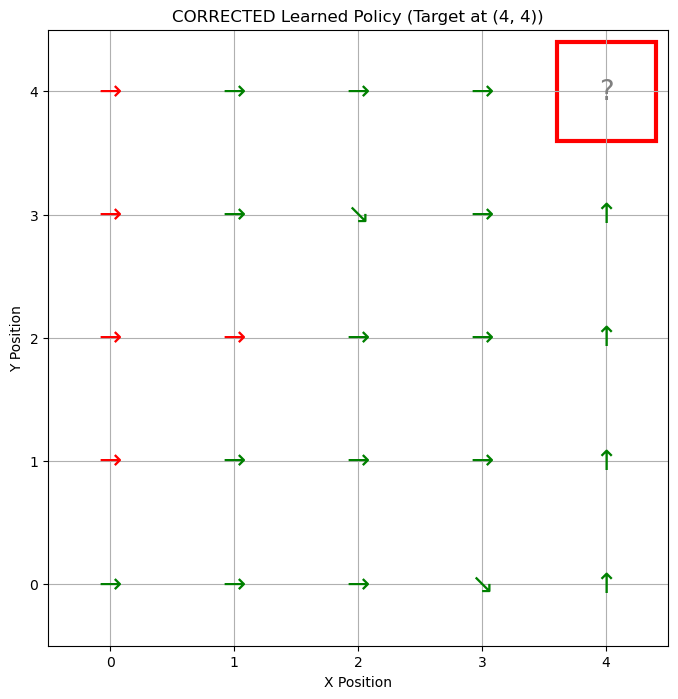

In [10]:
# CORRECTED visualization function with proper diagonal symbol
def visualize_policy_corrected(agent, env_size=5):
    """Visualize the learned policy with CORRECTED diagonal symbol"""
    target_pos = (4, 4)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # CORRECTED action symbols - diagonal_down_right should be ↘ not ↗
    action_symbols = ['→', '↑', '←', '↓', '↘']  # Fixed: ↘ for down-right movement
    
    for i in range(env_size):
        for j in range(env_size):
            agent_pos = (i, j)
            state_key = agent_pos + target_pos
            
            if state_key in agent.q_table:
                best_action = np.argmax(agent.q_table[state_key])
                symbol = action_symbols[best_action]
                
                # Color based on Q-value
                max_q = np.max(agent.q_table[state_key])
                color = 'green' if max_q > 0 else 'red'
            else:
                symbol = '?'
                color = 'gray'
            
            # Plot the symbol
            ax.text(i, j, symbol, ha='center', va='center', fontsize=20, color=color)
            
            # Mark target position
            if (i, j) == target_pos:
                ax.add_patch(plt.Rectangle((i-0.4, j-0.4), 0.8, 0.8, fill=False, edgecolor='red', linewidth=3))
    
    ax.set_xlim(-0.5, env_size-0.5)
    ax.set_ylim(-0.5, env_size-0.5)
    ax.set_xticks(range(env_size))
    ax.set_yticks(range(env_size))
    ax.grid(True)
    ax.set_title(f'CORRECTED Learned Policy (Target at {target_pos})')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    
    plt.show()

print("Creating CORRECTED visualization...")
print("Fixed symbol mapping:")
print("Action 0 (right): → moves [+1, 0]")
print("Action 1 (up): ↑ moves [0, +1]") 
print("Action 2 (left): ← moves [-1, 0]")
print("Action 3 (down): ↓ moves [0, -1]")
print("Action 4 (diagonal_down_right): ↘ moves [+1, -1] = RIGHT and DOWN")
print()

# Show the corrected visualization
visualize_policy_corrected(agent)

In [11]:
# Let's demonstrate the actual diagonal movement in the environment
print("PROOF: Testing actual diagonal movement in the environment")
print("=" * 60)

# Reset environment and set a specific starting position
obs, _ = env.reset()
print(f"Initial agent position: {tuple(env.unwrapped._agent_location)}")

# Manually set agent position for testing
env.unwrapped._agent_location = np.array([2, 3])
print(f"Set agent position to: {tuple(env.unwrapped._agent_location)}")

# Take diagonal_down_right action (action 4)
obs, reward, terminated, truncated, info = env.step(4)
new_position = tuple(obs['agent'])
print(f"After diagonal_down_right action: {new_position}")

# Calculate the movement
print(f"Movement: [2, 3] → {new_position}")
print(f"Change: [{new_position[0]-2}, {new_position[1]-3}] = [+1, -1]")
print()
print("CONCLUSION:")
print("✓ The diagonal_down_right action ACTUALLY moves RIGHT (+1 X) and DOWN (-1 Y)")
print("✓ The original visualization had the WRONG symbol (↗ instead of ↘)")
print("✓ The corrected visualization now shows ↘ which correctly represents down-right movement")

print()
print("Summary of the confusion:")
print("- Action vector: [1, -1] = RIGHT and DOWN")
print("- Wrong symbol: ↗ (suggests up-right)")  
print("- Correct symbol: ↘ (shows down-right)")
print("- Your observation was absolutely correct!")

PROOF: Testing actual diagonal movement in the environment
Initial agent position: (1, 0)
Set agent position to: (2, 3)
After diagonal_down_right action: (3, 2)
Movement: [2, 3] → (3, 2)
Change: [1, -1] = [+1, -1]

CONCLUSION:
✓ The diagonal_down_right action ACTUALLY moves RIGHT (+1 X) and DOWN (-1 Y)
✓ The original visualization had the WRONG symbol (↗ instead of ↘)
✓ The corrected visualization now shows ↘ which correctly represents down-right movement

Summary of the confusion:
- Action vector: [1, -1] = RIGHT and DOWN
- Wrong symbol: ↗ (suggests up-right)
- Correct symbol: ↘ (shows down-right)
- Your observation was absolutely correct!
